# SLICENET  network QoE  derived from QoS analysis

## Overview:
The POC experimental set up derives the application level QoE metrics by monitoring the Wordpress client’s response time with/without backgound stress. On one ICP, Jmeter acts as the client; it gets Wordpress pages and records the response time in its influxdb.  On another ICP, where the Wordpress service resides, Skydive collects QoS metrics, i.e. flows, related to the Wordpress service; Skydive stores its flows in elasticsearch. [Cognetive's network_stresser](https://github.com/cognetive/network_stresser/tree/master/tests/skydive_tests) is used to generate the background stress.

## Stage I:

[Classical statitics Analysis](https://drive.google.com/file/d/142FpFA_BjYh2hIZU3qlv67ibOoEdbxKe/view?usp=sharing)

## Stage II:
__Machine Learning__ to be discussed after stage I conclusion. 



In [238]:
#!pip install cufflinks==0.8.2 --user

In [239]:
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
#import cufflinks as cf

In [240]:
init_notebook_mode(connected=True)

In [241]:
# The code was removed by Watson Studio for sharing.

In [242]:
def plotJmeter(df,title):
    traces=[]
    for transaction in df['transaction'].unique():
        trace = go.Scatter(
            y=df[df['transaction']==transaction]['avg'],
            x=df[df['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction
        )    
        traces.append(trace)
  
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title="Response Time (ms)"
            )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [243]:
def plotJmeter2(df1,df2,title):
    traces=[]
    for transaction in df1['transaction'].unique():
        trace = go.Scatter(
            y=df1[df1['transaction']==transaction]['avg'],
            x=df1[df1['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with no background stress"
        )    
        traces.append(trace)
    for transaction in df2['transaction'].unique():
        trace = go.Scatter(
            y=df2[df2['transaction']==transaction]['avg'],
            x=df2[df2['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with background stress"
        )    
        traces.append(trace)        
  
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title="Response Time (ms)"
            )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [244]:
def plotSkydiveFlows2(df1,df2,title,y_feature,y_title):
    traces=[]
    for name in df1['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df1[df1['_source.NodeTID']==name][y_feature],
            x=df1[df1['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            #connectgaps=True,
            name=name+" with no background stress"
        )    
        traces.append(trace)
    for name in df2['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df2[df2['_source.NodeTID']==name][y_feature],
            x=df2[df2['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            #connectgaps=True,
            name=name+" with background stress"
        )    
        traces.append(trace)           
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title=y_title
            )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [245]:
def plotSkydiveFlows(df,title,y_feature,y_title):
    traces=[]
    for name in df['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df[df['_source.NodeTID']==name][y_feature],
            x=df[df['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            #connectgaps=True,
            name=name
        )    
        traces.append(trace)        
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
            ),
            yaxis=dict(
                title=y_title
            )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [246]:
def plot4(df1,df2,df3,df4,title):
    traces=[]
    for transaction in df1['transaction'].unique():
        trace = go.Scatter(
            y=df1[df1['transaction']==transaction]['avg'],
            x=df1[df1['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with no background stress",
            text = ["with no background stress"],
            textposition='top right'
        )    
        traces.append(trace)
    for transaction in df2['transaction'].unique():
        trace = go.Scatter(
            y=df2[df2['transaction']==transaction]['avg'],
            x=df2[df2['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with background stress"
        )    
        traces.append(trace)
    for name in df3['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df3[df3['_source.NodeTID']==name]['_source.RTT'],
            x=df3[df3['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with no background stress",
            xaxis='x2',
            yaxis='y2'
        )    
        traces.append(trace)
    for name in df4['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df4[df4['_source.NodeTID']==name]['_source.RTT'],
            x=df4[df4['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with background stress",
            xaxis='x2',
            yaxis='y2'            
        )    
        traces.append(trace)             
  
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title="ms"
            )
    )
    layout = go.Layout(
        title=title,
        xaxis=dict(
                       
            domain=[0, 1]
        ),
        yaxis=dict(
            title="response time (QoE)",
            domain=[0.55, 1]
            
        ),
        xaxis2=dict(
            #title="time",
            domain=[0, 1],
            anchor='y2'
        ),


        yaxis2=dict(
            title="RTT (QoE)",
            domain=[0, 0.45]
            
        ),
        showlegend=False,
        annotations = [
            dict(
                  #x = -0.0951769406393,
                  x = 0.0951769406393,
                  #y = 0.96972670892,
                  y = 1,
                  showarrow = False,
                  text = "Without Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  #x = 0.2951769406393,
                  x = 0.8,
                  #y = 0.96972670892,
                  y = 1,
                  showarrow = False,
                  text = "With Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  x = 0.0951769406393,
                  y = 0.36972670892,
                  showarrow = False,
                  text = "Without Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  x = 0.8,
                  y = 0.36972670892,
                  showarrow = False,
                  text = "With Stress",
                  xref = "paper",
                  yref = "paper"
            )            
            
        ]

    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [247]:
def plotQoEQoS(df1,df2,df3,df4,y_feature,y_title,title):
    traces=[]
    for transaction in df1['transaction'].unique():
        trace = go.Scatter(
            y=df1[df1['transaction']==transaction]['avg'],
            x=df1[df1['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with no background stress",
            text = ["with no background stress"],
            textposition='top right'
        )    
        traces.append(trace)
    for transaction in df2['transaction'].unique():
        trace = go.Scatter(
            y=df2[df2['transaction']==transaction]['avg'],
            x=df2[df2['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with background stress"
        )    
        traces.append(trace)
    for name in df3['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df3[df3['_source.NodeTID']==name][y_feature],
            x=df3[df3['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with no background stress",
            xaxis='x2',
            yaxis='y2'
        )    
        traces.append(trace)
    for name in df4['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df4[df4['_source.NodeTID']==name][y_feature],
            x=df4[df4['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with background stress",
            xaxis='x2',
            yaxis='y2'            
        )    
        traces.append(trace)             
  
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title="ms"
            )
    )
    layout = go.Layout(
        title=title,
        xaxis=dict(
                       
            domain=[0, 1]
        ),
        yaxis=dict(
            title="response time (QoE)",
            domain=[0.55, 1]
            
        ),
        xaxis2=dict(
            #title="time",
            domain=[0, 1],
            anchor='y2'
        ),


        yaxis2=dict(
            title=y_title,
            domain=[0, 0.45]
            
        ),
        showlegend=False,
        annotations = [
            dict(
                  #x = -0.0951769406393,
                  x = 0.0951769406393,
                  #y = 0.96972670892,
                  y = 1,
                  showarrow = False,
                  text = "Without Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  #x = 0.2951769406393,
                  x = 0.8,
                  #y = 0.96972670892,
                  y = 1,
                  showarrow = False,
                  text = "With Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  x = 0.0951769406393,
                  y = 0.36972670892,
                  showarrow = False,
                  text = "Without Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  x = 0.8,
                  y = 0.36972670892,
                  showarrow = False,
                  text = "With Stress",
                  xref = "paper",
                  yref = "paper"
            )            
            
        ]

    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [248]:
def plot6(df1,df2,df3,df4,df5,df6,title):
    traces=[]
    for transaction in df1['transaction'].unique():
        trace = go.Scatter(
            y=df1[df1['transaction']==transaction]['avg'],
            x=df1[df1['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with no background stress",
            text = ["with no background stress"],
            textposition='top right'
        )    
        traces.append(trace)
    for transaction in df2['transaction'].unique():
        trace = go.Scatter(
            y=df2[df2['transaction']==transaction]['avg'],
            x=df2[df2['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with background stress"
        )    
        traces.append(trace)
    for name in df3['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df3[df3['_source.NodeTID']==name]['_source.RTT'],
            x=df3[df3['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with no background stress",
            xaxis='x2',
            yaxis='y2'
        )    
        traces.append(trace)
    for name in df4['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df4[df4['_source.NodeTID']==name]['_source.RTT'],
            x=df4[df4['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with background stress",
            xaxis='x2',
            yaxis='y2'            
        )    
        traces.append(trace)
    for name in df5['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df5[df5['_source.NodeTID']==name]['time_to_FIN'],
            x=df5[df5['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with no background stress",
            xaxis='x3',
            yaxis='y3'
        )    
        traces.append(trace)
    for name in df6['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df6[df6['_source.NodeTID']==name]['time_to_FIN'],
            x=df6[df6['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with background stress",
            xaxis='x3',
            yaxis='y3'            
        )    
        traces.append(trace)            
  
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title="ms"
            )
    )
    layout = go.Layout(
        title=title,
        xaxis=dict(                       
            domain=[0, 1],
            anchor='y2'
        ),
        yaxis=dict(
            title="response time (QoE)",
            domain=[0, 0]
            
        ),
        xaxis2=dict(
            #title="time",
            domain=[0.55, 1],
            anchor='y2'
            
        ),
        yaxis2=dict(
            title="RTT (QoE)",
            domain=[0, 0.45]
            
        ),
        xaxis3=dict(
            #title="time",
            domain=[0.55, 1],
            anchor='y3'
        ),
        yaxis3=dict(
            title="Time to FIN (QoE)",
            domain=[0, 1]
            
        ),        
        showlegend=False,
        annotations = [
            dict(
                  #x = -0.0951769406393,
                  x = 0.0951769406393,
                  #y = 0.96972670892,
                  y = 1,
                  showarrow = False,
                  text = "Without Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  #x = 0.2951769406393,
                  x = 0.8,
                  #y = 0.96972670892,
                  y = 1,
                  showarrow = False,
                  text = "With Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  x = 0.0951769406393,
                  y = 0.36972670892,
                  showarrow = False,
                  text = "Without Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  x = 0.8,
                  y = 0.36972670892,
                  showarrow = False,
                  text = "With Stress",
                  xref = "paper",
                  yref = "paper"
            )            
            
        ]

    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [249]:
def getdfLaterHalf(df,time):    
    halfway =  (df[time].min() + (df[time].max() - df[time].min()) / 2)    
    return(df[df[time] >= halfway])


In [250]:
def getRTTDiff(df):
    dfRTTDiff = df[['_source.TrackingID','_source.Metric.Last','_source.NodeTID','_source.RTT']].copy()
    dfRTTDiff.sort_values(by=['_source.TrackingID','_source.Metric.Last','_source.NodeTID'], ascending=[True,True,True], inplace=True)
    dfRTTDiff['diffs'] = dfRTTDiff.groupby(['_source.TrackingID'])['_source.RTT'].transform(lambda x: x.diff().abs())
    #print(dfRTTDiff.head(10))
    dfRTTDiff = dfRTTDiff.groupby(['_source.TrackingID'], as_index=False).agg({'_source.NodeTID': ' - '.join, '_source.Metric.Last': 'first','diffs' : 'last'})
    return(dfRTTDiff)


In [251]:
def massageSkydiveFlows(df):
    #print(df.count()) 
    df = df[df['_source.Application'] == 'TCP']
    df = df[df['_source.Transport.Protocol'] == 'TCP']
    df = df[df['_source.Transport.B'] == 80]
    #print(df.count()) 
    df['flow_duration'] = df['_source.Metric.Last'] - df['_source.Metric.Start']
    df = df.dropna(subset=['flow_duration'])
    df['flow_duration'] = df['flow_duration'].astype(int).dropna()
    #df['flow_duration'] = df['flow_duration'].apply(lambda x: x*100) # convert to ms
    #print(dfSkydiveFlowsNoStress[['flow_duration','_source.RTT']].head(10)) 
    df['_source.Metric.Last'] = pd.to_datetime(df['_source.Metric.Last'],unit='ms')
    df['_source.Metric.Start'] = pd.to_datetime(df['_source.Metric.Start'],unit='ms') 
    df['_source.NodeTID'] = df['_source.NodeTID'].replace(['c989a779-c295-52da-6041-3f287488faa1'],'wp_eth0')
    #df['_source.NodeTID'] = df['_source.NodeTID'].replace(['8c451cd5-a37f-5e51-7d89-8c2cc2c5e88d'],'calico')
    #df = df[df['_source.NodeTID'] != 'b40081de-0060-5816-54c4-c3907e470941']
    #q = df['_source.RTT'].quantile(0.99)
    #df = df[df['_source.RTT']<q]

    q = df['flow_duration'].quantile(0.95)
    df = df[df['flow_duration']<q]    
    return(df)
    

In [252]:
def massageJmeter(df):
    df = df[df.transaction != 'internal']
    df = df[df['transaction'] != 'all']
    df["time"] = pd.to_datetime(df["time"],unit='ms')
    #df["avg"] = df["avg"].apply(lambda x: x*1000000)
    df = df.dropna(subset=['avg'])
    df['avg'] = df['avg'].astype(int)
    q = df['avg'].quantile(0.99)
    df = df[df['avg']<q]
    return(df)    
   

In [253]:
def massageIndex(df,begin_plus,end_less):
    df.begin = df.begin + (begin_plus*60000)
    df.end = df.end - (end_less*60000)
    return(df)

In [254]:
def labelDF(dfLabels,df,time):
    a = df[time].values
    bh = dfLabels.end.values
    bl = dfLabels.begin.values

    i, j = np.where((a[:, None] > bl) & (a[:, None] < bh))

    return (pd.DataFrame(
        np.column_stack([df.values[i], dfLabels.values[j]]),
        columns=df.columns.append(dfLabels.columns)
    ))

In [255]:
def maxMedian(dfIndex,dfJmeter):
    maxM=0
    maxBegin=0
    maxEnd=0
    maxStress=''
    for index, row in dfIndex.iterrows():
        if row.stress_test == "no_stress":
            noStressIndex=index
            continue
        df=dfJmeter[(dfJmeter['time'] > row.begin) & (dfJmeter['time'] < row.end)]
        m=df.avg.median()
        if m > maxM:
            maxM=m
            maxIndex=index
            maxStress=row.stress_test
            maxNoStressPair=noStressIndex
    return(maxIndex,maxNoStressPair)        
        


In [256]:
def getDFs(suffixes):
    jMeterFrame = []
    skydiveFrame = []
    indexFrame = []
    for s in suffixes:
        dfTemp,err = getDF("jmeter{}.csv".format(s))
        if err != "":
            print(err)
            raise Error(err)
        jMeterFrame.append(dfTemp)    
       
    
        dfTemp,err = getDF("skydiveFlows{}.csv".format(s))
        if err != "":
            print(err)
            raise Error(err)
        skydiveFrame.append(dfTemp)
        
        dfTemp,err = getDF("workload_stress_begin_end_{}.csv".format(s))    
        if err != "":
            print(err)
            raise Error(err)
        indexFrame.append(dfTemp)
        
    dfJmeter=pd.concat(jMeterFrame)
    dfSkydiveFlows=pd.concat(skydiveFrame)
    dfIndex=pd.concat(indexFrame)            
    
    return(dfJmeter,dfSkydiveFlows,dfIndex)

In [257]:
 
#dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190507","190417"])
#dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190417"])
dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190507"])
#dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190507","190510"])
#dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190510"])

dfIndex = massageIndex(dfIndex,1,2.5)
 
    
dfJmeterLabeled = labelDF(dfIndex,dfJmeter,'time')

dfSkydiveFlowsLabeled = labelDF(dfIndex,dfSkydiveFlows,'_source.Metric.Last')

dfJmeterLabeled = dfJmeterLabeled[dfJmeterLabeled.begin.isin(dfSkydiveFlowsLabeled.begin.unique())]



maxMedianIndex,maxNoStressPair=maxMedian(dfIndex,dfJmeter)
#print(maxMedianIndex,maxNoStressPair)
noStressBegin = dfIndex.iloc[maxNoStressPair]['begin']
noStressEnd = dfIndex.iloc[maxNoStressPair]['end']
withStressBegin = dfIndex.iloc[maxMedianIndex]['begin']
withStressEnd = dfIndex.iloc[maxMedianIndex]['end']

#print(dfSkydiveFlows['_source.Metric.Last'].max(),noStressBegin)   
   
dfJmeterNoStress = dfJmeter[(dfJmeter['time'] >= noStressBegin) & (dfJmeter['time'] <= noStressEnd)] 
dfSkydiveFlowsNoStress = dfSkydiveFlows[(dfSkydiveFlows['_source.Metric.Last'] >= noStressBegin) &  (dfSkydiveFlows['_source.Metric.Last'] <= noStressEnd)]
dfJmeterWithStress = dfJmeter[(dfJmeter['time'] >= withStressBegin) & (dfJmeter['time'] <= withStressEnd)] 
dfSkydiveFlowsWithStress = dfSkydiveFlows[(dfSkydiveFlows['_source.Metric.Last'] >= withStressBegin) &  (dfSkydiveFlows['_source.Metric.Last'] <= withStressEnd)] 
    

    
pd.options.mode.chained_assignment = None    
    
#dfJmeterNoStress = dfJmeter[(dfJmeter['time'] > 1554109413813) & (dfJmeter['time'] < 1554110584822)] 
#dfSkydiveFlowsNoStress = dfSkydiveFlows[(dfSkydiveFlows['_source.Metric.Last'] > 1554109413813) &  (dfSkydiveFlows['_source.Metric.Last'] < 1554110584822)]     
#dfJmeterWithStress = dfJmeter[(dfJmeter['time'] > 1554110584865) & (dfJmeter['time'] < 1554112922403)] 
#dfSkydiveFlowsWithStress = dfSkydiveFlows[(dfSkydiveFlows['_source.Metric.Last'] > 1554110584865) &  (dfSkydiveFlows['_source.Metric.Last'] < 1554112922403)] 

dfJmeterLabeled = massageJmeter(dfJmeterLabeled)
dfSkydiveFlowsLabeled = massageSkydiveFlows(dfSkydiveFlowsLabeled)

dfJmeterNoStress = massageJmeter(dfJmeterNoStress)    
dfJmeterWithStress = massageJmeter(dfJmeterWithStress)


dfSkydiveFlowsNoStress = massageSkydiveFlows(dfSkydiveFlowsNoStress)    
dfSkydiveFlowsWithStress =  massageSkydiveFlows(dfSkydiveFlowsWithStress) 


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning:

Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.



In [258]:
 
dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190512"])

dfIndex = massageIndex(dfIndex,1,2.5)
 
    
dfJmeterLabeledTest = labelDF(dfIndex,dfJmeter,'time')

dfSkydiveFlowsLabeledTest = labelDF(dfIndex,dfSkydiveFlows,'_source.Metric.Last')

dfJmeterLabeledTest = dfJmeterLabeledTest[dfJmeterLabeledTest.begin.isin(dfSkydiveFlowsLabeledTest.begin.unique())]

   
pd.options.mode.chained_assignment = None    
  
dfJmeterLabeledTest = massageJmeter(dfJmeterLabeledTest)
dfSkydiveFlowsLabeledTest = massageSkydiveFlows(dfSkydiveFlowsLabeledTest)




/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning:

Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.



# jmeter response times and skydive flows without/with background stress 

In [259]:
plotQoEQoS(dfJmeterNoStress,dfJmeterWithStress,dfSkydiveFlowsNoStress,dfSkydiveFlowsWithStress,'flow_duration','Flow Duration (QoS)',"HTTP Non-Persistent Connection <br> Wordpress Response Time (QoE) relative to Flow Duration (QoS)")

In [260]:
#plotQoEQoS(dfJmeterNoStress,dfJmeterWithStress,dfSkydiveFlowsNoStress,dfSkydiveFlowsWithStress,'_source.RTT','RTT (QoS)',"Wordpress Response Time (QoE) relative to Flow Duration (QoS)")

In [261]:
#plot6(dfJmeterNoStress,dfJmeterWithStress,dfSkydiveFlowsNoStress,dfSkydiveFlowsWithStress,dfSkydiveFlowsNoStress,dfSkydiveFlowsWithStress,title="Wordpress Response Time (QoE) relative to RTT (QoS) and time to FIN (QoE)")

In [262]:
plotJmeter2(dfJmeterNoStress,dfJmeterWithStress,"wordpress response times (QoE) without/with background stress")

In [263]:
#plotSkydiveFlows2(dfSkydiveFlowsNoStress,dfSkydiveFlowsWithStress,'wordpress time to RTT (QoS) without/with background stress','_source.RTT',"RTT (ns)")

In [264]:
plotSkydiveFlows2(dfSkydiveFlowsNoStress,dfSkydiveFlowsWithStress,'wordpress flow duration (QoS) without/with background stress','flow_duration',"flow duration (ms)")

In [265]:
plotJmeter(dfJmeterNoStress,"wordpress average response time (QoE) without background stress")

In [266]:
plotJmeter(dfJmeterWithStress,"wordpress average response time (QoE) with background stress")

In [267]:
#plotSkydiveFlows(dfSkydiveFlowsNoStress,'wordpress RTT (QoS) without background stress','_source.RTT',"RTT (ns)")

In [268]:
#plotSkydiveFlows(dfSkydiveFlowsWithStress,'wordpress RTT (QoS) with background stress','_source.RTT','RTT (ns)')

In [269]:
plotSkydiveFlows(dfSkydiveFlowsNoStress,'wordpress flow duration (QoS) without background stress','flow_duration','flow duration (ms)')

In [270]:
plotSkydiveFlows(dfSkydiveFlowsWithStress,'wordpress flow duration (QoS) with background stress','flow_duration','flow duration (ms)')

In [271]:
#dfRTTDiffNoStress = getRTTDiff(dfSkydiveFlowsNoStress)

In [272]:
#dfRTTDiffWithStress = getRTTDiff(dfSkydiveFlowsWithStress)

In [273]:
#plotSkydiveFlows2(dfRTTDiffNoStress,dfRTTDiffWithStress,"wordpress RTT differences without & with background stress","diffs","RTT (NS)")

In [274]:
#plotSkydiveFlows(dfRTTDiffNoStress,"wordpress RTT differences with no background stress","diffs","RTT (NS)")

In [275]:
#plotSkydiveFlows(dfRTTDiffWithStress,"wordpress RTT differences with background stress","diffs","RTT (NS)")

In [276]:
## aggregation details

### response time with no background stress

In [277]:
print(dfJmeterNoStress.groupby(['transaction']).agg({'avg': ['min','max','median','std']}).dropna())

             avg                      
             min  max median       std
transaction                           
homepage     567  584    583  8.532292


### response time with background stress

In [278]:
print(dfJmeterWithStress.groupby(['transaction']).agg({'avg': ['min','max','median','std']}).dropna())

              avg                         
              min   max median         std
transaction                               
homepage     7916  8579   8160  247.117966


In [279]:
#print(dfSkydiveFlowsNoStress.groupby(['_source.NodeTID']).agg({'_source.RTT': ['min','max','median','std']}))

In [280]:
#print(dfSkydiveFlowsWithStress.groupby(['_source.NodeTID']).agg({'_source.RTT': ['min','max','median','std']}))

### flow duration without background stress

In [281]:
print(dfSkydiveFlowsNoStress.groupby(['_source.NodeTID']).agg({'flow_duration': ['min','max','median','std']}))

                                     flow_duration                       
                                               min  max median        std
_source.NodeTID                                                          
f4a3fab0-ab6c-5cc7-7104-74db7b937ab9             2  106      4  33.439916


### flow duration with background stress

In [282]:
print(dfSkydiveFlowsWithStress.groupby(['_source.NodeTID']).agg({'flow_duration': ['min','max','median','std']}))

                                     flow_duration                        
                                               min   max median        std
_source.NodeTID                                                           
f4a3fab0-ab6c-5cc7-7104-74db7b937ab9             1  3512    250  986.01541


## examine later half of data sets

### response time with no background stress (later half of data set)

In [283]:
print(getdfLaterHalf(dfJmeterNoStress,'time').groupby(['transaction']).agg({'avg': ['min','max','median','std']}).dropna())

             avg                 
             min  max median  std
transaction                      
homepage     583  583    583  0.0


### response time with background stress (later half of data set)

In [284]:
print(getdfLaterHalf(dfJmeterWithStress,'time').groupby(['transaction']).agg({'avg': ['min','max','median','std']}).dropna())

              avg                         
              min   max median         std
transaction                               
homepage     7916  8160   8034  122.013114


### Flow duration  with background stress (later half of data set)

In [285]:
print(getdfLaterHalf(dfSkydiveFlowsNoStress,'_source.Metric.Last').groupby(['_source.NodeTID']).agg({'flow_duration': ['min','max','median','std']}))

                                     flow_duration                      
                                               min  max median       std
_source.NodeTID                                                         
f4a3fab0-ab6c-5cc7-7104-74db7b937ab9             2  106      4  35.14378


### Flow duration with background stress (later half of data set)

In [286]:
print(getdfLaterHalf(dfSkydiveFlowsWithStress,'_source.Metric.Last').groupby(['_source.NodeTID']).agg({'flow_duration': ['min','max','median','std']}))

                                     flow_duration                         
                                               min   max median         std
_source.NodeTID                                                            
f4a3fab0-ab6c-5cc7-7104-74db7b937ab9             1  3512  262.5  970.539946


## Examine multiple samples

In [287]:
def plotAgg2(df1,df2,yAgg1,yfeature1,yAgg2,yfeature2,xfeature,yname1,yname2,xtitle,ytitle,title):
    traces=[]
    trace = go.Scatter(
            y=df1[yAgg1][yfeature1],
            x=df1[xfeature],
            mode = 'markers',
            connectgaps=True,
            name=yname1
    )    
    traces.append(trace)
    trace = go.Scatter(
            y=df2[yAgg2][yfeature2],
            x=df2[xfeature],
            mode = 'markers',
            connectgaps=True,
            name=yname2
    )    
    traces.append(trace)
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title=xtitle
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title=ytitle
            )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [288]:
for b in dfJmeterLabeled.begin.unique():
    stress = dfIndex[dfIndex.begin == b].stress_test
    plotJmeter(dfJmeterLabeled[dfJmeterLabeled.begin == b],"wordpress response time (QoE) sample "+str(b)+" ("+stress+")")
    plotSkydiveFlows(dfSkydiveFlowsLabeled[dfSkydiveFlowsLabeled.begin == b],"wordpress flow duration (QoS) sample "+str(b)+" ("+stress+")","flow_duration","flow duration (ms)")

   

In [289]:
def plot4Ms(df,xFeature,yFeature,xTitle,yTitle,title):
    #s = list(map(str,df['begin']))
    #print(s)
    xList = list(range(len(df['begin'])))
    meanBar = go.Bar(
        y=df[yFeature]['mean'],
        #x=df[xFeature].astype(str),
        x = xList,
        name='mean',
        text=df[yFeature]['mean'],
        textposition="outside",
        textfont=dict(size=18),
        #marker=dict(line=dict(width=1.5)),
        #opacity=5,
        #width=10,
        orientation='vertical'
    )
    medianBar = go.Bar(
        y=df[yFeature]['median'],
        #x=df[xFeature].astype(str),
        x = xList,
        name='median',
        text=df[yFeature]['median'],
        textposition="outside",
        textfont=dict(size=18),
        #marker=dict(line=dict(width=1.5)),
        #opacity=5,
        #width=10,
        orientation='vertical'
    )
    
    minBar = go.Bar(
        y=df[yFeature]['min'],
        #x=df[xFeature].astype(str),
        x=xList,
        name='min',
        #text=df[yFeature]['min'],
        #textposition="outside",
        #opacity=5,
        #width=3,
        orientation='vertical'
    )
    maxBar = go.Bar(
        y=df[yFeature]['max'],
        #x=df[xFeature].astype(str),
        x=xList,
        name='max',
        #text=df.duration['max'],
        #textposition="outside",
        #opacity=5,
        #width=1,
        orientation='vertical'
        
    )
    
    data = [minBar,medianBar,meanBar,maxBar]
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                #tickformat = '%d',
                title=xTitle,
                #tickvals=df[xFeature].astype(str),
                tickvals=xList                
            ),
            yaxis=dict(
                title=yTitle
            )
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [290]:
dfJmeterLabeledAgg = dfJmeterLabeled.groupby(['begin']).agg({'avg': ['min','max','median','mean','std']}).dropna().reset_index()
plot4Ms(dfJmeterLabeledAgg,'begin','avg','test samples','response time (ms)','wordpress response time (QoE)')

In [291]:
#dfSkydiveFlowsLabeledAgg = dfSkydiveFlowsLabeled.groupby(['begin','stress_test']).agg({'flow_duration': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsLabeledAgg = dfSkydiveFlowsLabeled.groupby(['begin']).agg({'flow_duration': ['min','max','median','mean','std']}).dropna().reset_index()
plot4Ms(dfSkydiveFlowsLabeledAgg,'begin','flow_duration','test samples','flow duration (ms)','wordpress flow duration (Qos)')
#print(dfSkydiveFlowsLabeledAgg)
#dfSkydiveFlowsLabeledAgg['flow_duration']['median'].plot(kind='line',title='median flow duration (QoS)')

In [292]:
#print(dfSkydiveFlowsLabeled.count())
#print(dfSkydiveFlowsLabeled['_source.LastUpdateMetric.ABBytes'].unique())
#print(dfSkydiveFlowsLabeled['_source.LastUpdateMetric.BABytes'].unique())
#todo have to merge these for flowduration
vc = dfSkydiveFlowsLabeled["_source.UUID"].value_counts()
#print(dfSkydiveFlowsLabeled.count())
#print( vc[vc > 1])
#print(dfSkydiveFlowsLabeled[dfSkydiveFlowsLabeled["_source.UUID"] == 'd0ce31611f3d1317' ])

In [293]:
dfJmeterLabeledAgg1 = dfJmeterLabeled.groupby(['stress_test']).agg({'avg': ['min','max','median','mean','std']}).dropna()
print(dfJmeterLabeledAgg1)
#dfJmeterLabeledAgg1['avg']['median'].plot(kind='line',title='median avg resonse time (QoE)')

                                 avg                                        
                                 min   max  median         mean          std
stress_test                                                                 
no_stress                        401   648   516.0   528.058824    58.649933
stress-iperf-r1g1t10_test.yaml  2961  4681  4334.5  4129.533333   537.138667
stress-iperf-r1g1t20_test.yaml   468  5707  2647.0  3150.070175  1983.003979
stress-iperf-r1g1t30_test.yaml  2855  6705  4119.5  4197.571429   629.784325
stress-iperf-r1g1t50_test.yaml  5787  8347  6992.0  6918.187500   844.790199


In [294]:
dfSkydiveFlowsLabeledAgg1 = dfSkydiveFlowsLabeled.groupby(['stress_test']).agg({'flow_duration': ['min','max','median']}).dropna()
print(dfSkydiveFlowsLabeledAgg1)
#dfSkydiveFlowsLabeledAgg1['flow_duration']['median'].plot(kind='line',title='median flow duration (QoS)')

                               flow_duration             
                                         min   max median
stress_test                                              
no_stress                                  1   251    7.0
stress-iperf-r1g1t10_test.yaml             0  2229  151.5
stress-iperf-r1g1t20_test.yaml             2  2148   17.0
stress-iperf-r1g1t30_test.yaml             1  2203   50.0
stress-iperf-r1g1t50_test.yaml             1  2213  150.0


In [295]:
#plotAgg2(dfJmeterLabeledAgg,dfSkydiveFlowsLabeledAgg,'avg','median','flow_duration','median','begin','median avg response time','median flow duration (QoS)','begin','millisecond','HTTP Non-Persistent Connection (multiple sample runs)<br> median avg response time (QoE) and flow duration (Qos)' )

In [296]:
#plotAgg2(dfJmeterLabeledAgg1.reset_index(),dfSkydiveFlowsLabeledAgg1.reset_index(),'avg','median','flow_duration','median','begin','median avg response time','median flow duration (QoS)','begin','millisecond','median avg response time (QoE) and flow duration (Qos)' )

## correlation on aggregations of avg response time (QoE) and flow duration (Qos) (merge based on begin time for multiple samples)

In [297]:
df1 = dfJmeterLabeledAgg
df2 = dfSkydiveFlowsLabeledAgg
#df1 = df1[['time','avg']]
#df2 = df2[['_source.Metric.Last','flow_duration']]
dfMerged = pd.merge(df1,df2,left_on='begin',right_on='begin').dropna()
#df = df[df['flow_duration'] != 0]
#print(df.head())
#print(df.count())
#print(df['avg']['median'].corr(df['flow_duration']['median'],method='spearman'))
print("median correlation",dfMerged['avg']['median'].corr(dfMerged['flow_duration']['median'],method='pearson'))
print("mean correlation",dfMerged['avg']['mean'].corr(dfMerged['flow_duration']['mean'],method='pearson'))
print("min correlation",dfMerged['avg']['min'].corr(dfMerged['flow_duration']['min'],method='pearson'))
print("max correlation",dfMerged['avg']['max'].corr(dfMerged['flow_duration']['max'],method='pearson'))
print("std correlation",dfMerged['avg']['std'].corr(dfMerged['flow_duration']['std'],method='pearson'))

median correlation 0.76967839994
mean correlation 0.901129447897
min correlation -0.137843391238
max correlation 0.927547840695
std correlation 0.423968100693


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/generic.py:2530: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



## QoS to QoE estimate (test set from original samples)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Intercepts 252.25385324
      Coefficient
max     -1.863286
mean   -11.986353
std     24.779809
R2 score: 0.95


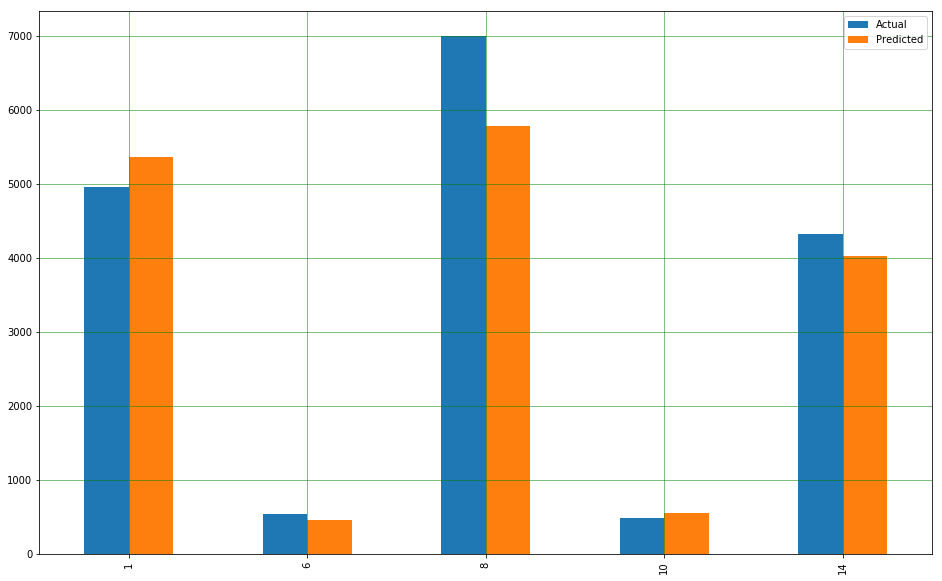

         Actual    Predicted    % error
1   4963.520000  5363.233695  -8.053029
6    544.000000   465.837846  14.368043
8   6989.833333  5785.346643  17.231980
10   487.750000   555.660038 -13.923124
14  4319.142857  4026.495955   6.775578


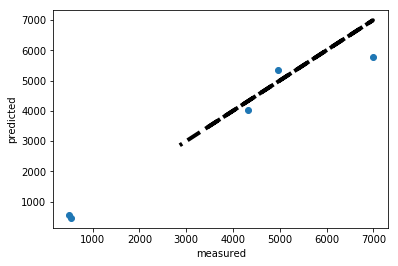

In [298]:
from sklearn.model_selection import train_test_split
from sklearn                        import metrics, svm
from sklearn.linear_model           import LinearRegression
from sklearn.linear_model           import LogisticRegression
from sklearn.tree                   import DecisionTreeClassifier
from sklearn.neighbors              import KNeighborsClassifier
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis
from sklearn.naive_bayes            import GaussianNB
from sklearn.svm                    import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
#data_train, data_test, target_train, target_test = train_test_split(df['flow_duration']['mean'],df['avg']['mean'], test_size = 0.30, random_state = 10)
#print(df.count())
dfAvg = dfMerged['avg']['mean']
dfFlowDuration = dfMerged['flow_duration']
columns = ['min','median']
dfFlowDuration = dfFlowDuration.drop(columns,axis=1)
#print(dfAvg.count())
#print(dfFlowDuration.count())

dfJmeterLabeledAggTest = dfJmeterLabeledTest.groupby(['begin']).agg({'avg': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsLabeledAggTest = dfSkydiveFlowsLabeledTest.groupby(['begin']).agg({'flow_duration': ['min','max','median','mean','std']}).dropna().reset_index()
dfAvgTest = dfJmeterLabeledAggTest['avg']['mean']
dfFlowDurationTest = dfSkydiveFlowsLabeledAggTest['flow_duration']
dfFlowDurationTest = dfFlowDurationTest.drop(columns,axis=1)
#print(dfAvgTest.count())
#print(dfFlowDurationTest.count())

#print("dfAvg")
#print(dfAvg)
#print("dfFlowDuration")
#print(dfFlowDuration)
#x_train, x_test, y_train, y_test = train_test_split(df['flow_duration']['mean'], df['avg']['mean'], test_size=0.25, random_state=0)

#print(x_test)
#print(y_test)
#for f in [LinearRegression(),svm.SVR()]:
for f in [LinearRegression()]:    
#clf = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(dfFlowDuration,dfAvg, test_size=0.25, random_state=0)
    clf = f    
    print(f)
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Intercepts',model.intercept_)
    # The coefficients
    coeff_df = pd.DataFrame(model.coef_, dfFlowDuration.columns, columns=['Coefficient'])  
    print(coeff_df)
    # The mean squared error
    #print("Mean squared error: %.2f"
    #  % mean_squared_error(y_test, y_pred))
    # Explained variance score: 1 is perfect prediction
    print('R2 score: %.2f' % r2_score(y_test, y_pred))
    dfEstimation = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})    
    dfEstimation.plot(kind='bar',figsize=(16,10))

    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    
    dfEstimation['% error'] = ((dfEstimation['Actual'] - dfEstimation['Predicted'] ) / dfEstimation['Actual']) * 100
    print(dfEstimation)
    
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.mean(), y_test.median(),  y_test.max(),y_test.std(),], [y_test.mean(), y_test.median(), y_test.max(), y_test.std()], 'k--', lw=4)
    ax.set_xlabel('measured')
    ax.set_ylabel('predicted')
    plt.show()
    
    #plt.scatter(X_test, y_test,  color='gray')
    #plt.plot(X_test, y_pred, color='red', linewidth=2)
    #plt.show()

    
    # Plot outputs
    #print(x_test.shape)
    #print(y_test.shape)
    #plt.scatter(x_test['mean'], y_test,  color='black')
    #plt.plot(x_test, y_pred, color='blue', linewidth=3)

    #plt.xticks(())
    #plt.yticks(())

## QoS to QoE estimate with separate test set (not from model's source db)

estimate with seperate test set (not from model's source db)
      Coefficient
max     -1.890307
mean   -11.401534
std     24.732267
R2 score: 0.90


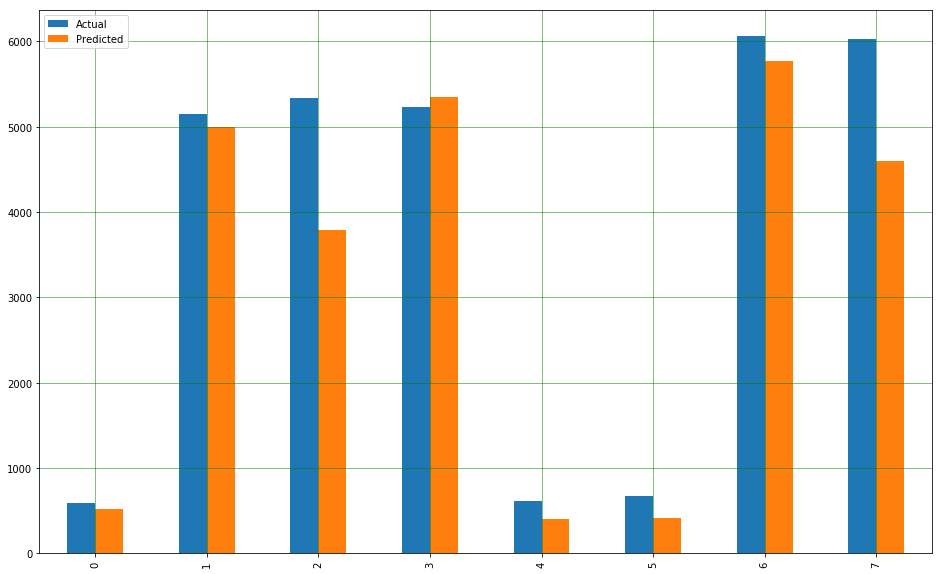

        Actual    Predicted    % error
0   586.750000   526.064042  10.342728
1  5145.428571  4995.006584   2.923410
2  5335.444444  3793.786772  28.894644
3  5230.384615  5350.521521  -2.296904
4   610.750000   403.252268  33.974250
5   678.250000   410.489505  39.478142
6  6066.666667  5774.374846   4.817997
7  6025.700000  4601.541068  23.634747


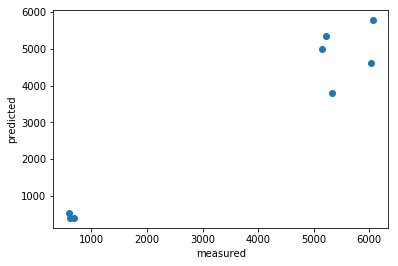

In [299]:
    #plt.show()
    print("estimate with seperate test set (not from model's source db)")
    X_train, X_test, y_train, y_test = train_test_split(dfFlowDuration,dfAvg, test_size=0.0, random_state=0)
    model = clf.fit(X_train, y_train)
    coeff_df = pd.DataFrame(model.coef_, dfFlowDuration.columns, columns=['Coefficient'])  
    print(coeff_df)
    y_pred = model.predict(dfFlowDurationTest)
    print('R2 score: %.2f' % r2_score(dfAvgTest, y_pred))
    dfEstimation = pd.DataFrame({'Actual': dfAvgTest, 'Predicted': y_pred})
    dfEstimation.plot(kind='bar',figsize=(16,10))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()    
    dfEstimation['% error'] = ((dfEstimation['Actual'] - dfEstimation['Predicted'] ) / dfEstimation['Actual']) * 100
    print(dfEstimation)
   
    fig, ax = plt.subplots()
    ax.scatter(dfAvgTest, y_pred)
    ax.plot([dfAvgTest.mean(), y_test.median(),  y_test.max(),y_test.std(),], [y_test.mean(), y_test.median(), y_test.max(), y_test.std()], 'k--', lw=4)
    ax.set_xlabel('measured')
    ax.set_ylabel('predicted')
    plt.show()
    

## Conclusion
* In this experiment we have demonstrated that QoE, i.e. response time, can be inferred from QoS, i.e. flow duration.  


## Next Step (Machine Learning)
[Machine Learning Analysis](https://drive.google.com/file/d/1923f_2jRvK3MhftrSlals1EeVgUAauIo/view?usp=sharing)
### challenges
1. Big Data: 
  * handling large amount of monitoring data from both skydive and jmeter
  * analysis may require spark (currently using pandas)
  * moving the skydive and jmeter output outside of the firewall would simplify data analysis
2. Test orchestration:  
  * synchronizing netstress tool and jmeter/wordpress
3. dataset labeling:
  * is merging the skydive's elasticsearch ('_source.Metric.Last) and jmeter's influxdb ('time') sufficient or do we label rows with/without stress?

## skydive (feedback)
* skydive's GUI is very busy and dense.  It hard for a new comer to make sense.
* it is not obvious how to write a capture.
* k8s "dialect" would be helpful.
* could service flow capture creation be automated?
* include capture name in elasticsearch would make it more user friendly.
* ingress capture has 0 rtt
* python client does not support BPF filters or capture names